# EDA
NOTES
NOTES

In [2]:
# Import modules
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

ROOT_dir = os.path.abspath('')
dataFolder = ROOT_dir + '/data'

In [3]:
# Load CSV in to a dataframe
raw = pd.read_csv(dataFolder + '/2009-2014_RedCross_DisasterCases.csv',
                 encoding = "ISO-8859-1",
                 error_bad_lines = False)

In [4]:
print('Number of columns:',raw.shape[1])
print('Number of rows:',raw.shape[0])
print()

# Count number of NaN per column, convert series to dataframe
raw_info_df = raw.isnull().sum().to_frame()

# Reset df index, rename columns
raw_info_df = raw_info_df.reset_index()
raw_info_df.columns = ['column_name','NaN_count']

# Add column to df containing the data type of each column
temp = raw.dtypes.to_frame()
raw_info_df['data_type'] = temp.loc[:,0].tolist()

# Count number of unique values for each column
colNames = raw_info_df['column_name'].tolist()
raw_info_df['unique_value_count'] = np.nan
#raw_info_df['unique_values'] = np.nan
for columnName in raw.columns.tolist():
    idx = colNames.index(columnName)
    temp = raw[colNames[idx]].value_counts(dropna = True)
    temp_len = len(temp)
    raw_info_df.loc[idx,'unique_value_count'] = temp_len

# Display first 20 rows
raw_info_df.head(20)

Number of columns: 41
Number of rows: 566772



,column_name,NaN_count,data_type,unique_value_count
0,case_num,0,object,561294.0
1,incident_disaster_date,0,object,2277.0
2,incident_disaster_num,0,object,344295.0
3,dr_type,0,object,7.0
4,event_type_old_categories,5,object,50.0
5,event_type_new_categories,5,object,33.0
6,incident_disaster_fiscal_year,0,object,8.0
7,chapter_code,4414,float64,265.0
8,chapter_name,4414,object,264.0
9,region_code,1847,object,62.0


In [5]:
# Examine why columns that should only contain numeric information is dtype object
colNames = ['age_5_or_under_num', 'age_62_to_69_num', 'age_6_to_61_num',
'age_over_69_num', 'female_num', 'male_num', 'gender_undeclared_num',
'afro_american_num', 'native_american_num', 'asian_num',
'caucasian_num', 'hispanic_num', 'ethnicity_undeclared_num']
for cols in colNames:
    print(cols,'\n',raw[cols].value_counts(),'\n',sep = '')

age_5_or_under_num
0                  334487
1                   76765
CAS 2.0             61410
GNY CAS No Data     37045
2                   34993
3                    9753
4                    2347
5                     488
6                     116
7                      28
8                       9
9                       5
12                      1
Name: age_5_or_under_num, dtype: int64

age_62_to_69_num
0                  416040
CAS 2.0             61410
GNY CAS No Data     37045
1                   36749
2                    6076
3                      94
4                      29
6                       4
Name: age_62_to_69_num, dtype: int64

age_6_to_61_num
1                  419890
CAS 2.0             61410
0                   39102
GNY CAS No Data     37045
Name: age_6_to_61_num, dtype: int64

age_over_69_num
0                  411554
CAS 2.0             61410
1                   38371
GNY CAS No Data     37045
2                    8280
3                     463
4          

In [6]:
# Force to numeric
for col in colNames:
    raw[col] = pd.to_numeric(raw[col], errors = 'coerce')

# Understand how the data are distributed across regions
Red Cross regions and States

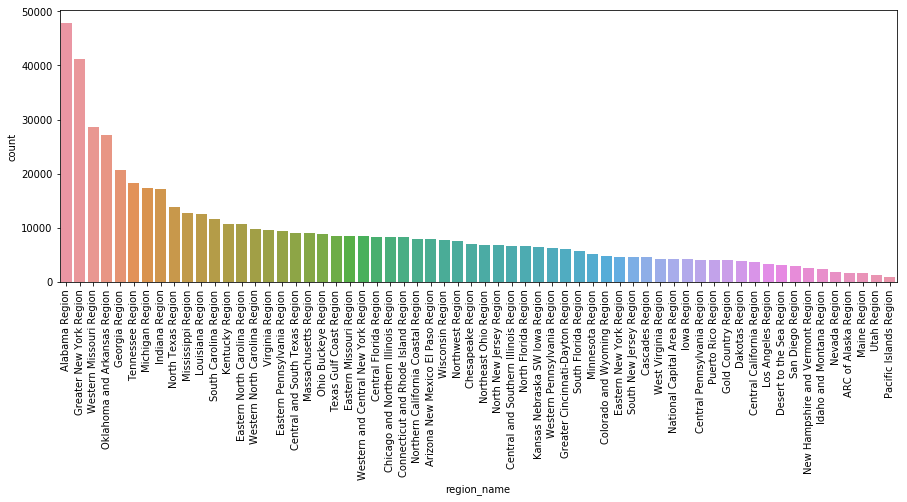

In [7]:
# Prepare dataframe, all cases
rc_regions = raw['region_name'].value_counts(dropna = True).to_frame()
rc_regions = rc_regions.reset_index()
rc_regions.columns = ['region_name','count']

# Plot total case counts against region
f, ax = plt.subplots(figsize=(15, 5))
ax = sns.barplot(y = rc_regions['count'], x = rc_regions['region_name'])
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.show()

In [8]:
# Prepare dataframe, fire cases only

# Build regex
def converter(list):
    output=""
    for letter in list:
        if letter == ' ':
            output += '[ ]'
        else:
            output += "[" + letter.upper() + letter.lower() + "]"
    return output

def build_region_df(df,columnName,idx,cols):
    temp = df.loc[df.index[idx],columnName].value_counts(dropna = True).to_frame()
    temp = temp.reset_index()
    temp.columns = cols
    return temp

# Show counts of target values
# Fire : Single Family, Fire : Multi-Family, Fire
print(raw['event_type_old_categories'].value_counts(dropna = True)[:3])
total_fire = raw['event_type_old_categories'].value_counts()[:3].sum()
print(total_fire)

# Find rows in dataframe that contain target values
idx = np.where(raw['event_type_old_categories'].str.contains(converter('Fire : Single Family'), na = False)
              | raw['event_type_old_categories'].str.contains(converter('Fire : Multi-Family'), na = False)
              | raw['event_type_old_categories'].str.match(converter('Fire') + '$', na = False))

if len(idx[0]) != total_fire:
    print('WARNING: The appropriate fire cases were not found...')
else:
    # Prepare dataframe, all cases
    rc_regions_fire = build_region_df(raw,'region_name',idx[0],['region_name','all_fires_count'])
    
    # Add column for "Fire : Single Family" cases only
    idx = np.where(raw['event_type_old_categories'].str.contains(converter('Fire : Single Family'), na = False))
    temp_df = build_region_df(raw,'region_name',idx[0],['region_name','fire_single_count'])
    rc_regions_fire = rc_regions_fire.join(temp_df.set_index('region_name'), on = 'region_name')
    
    # Add column for "Fire : Multi Family" cases only
    idx = np.where(raw['event_type_old_categories'].str.contains(converter('Fire : Multi-Family'), na = False))
    temp_df = build_region_df(raw,'region_name',idx[0],['region_name','fire_multi_count'])
    rc_regions_fire = rc_regions_fire.join(temp_df.set_index('region_name'), on = 'region_name')
    
    # Add column for "Fire" cases only
    idx = np.where(raw['event_type_old_categories'].str.match(converter('Fire') + '$', na = False))
    temp_df = build_region_df(raw,'region_name',idx[0],['region_name','fire_count'])
    rc_regions_fire = rc_regions_fire.join(temp_df.set_index('region_name'), on = 'region_name')

Fire : Single Family    245639
Fire : Multi-Family     139698
Fire                     78825
Name: event_type_old_categories, dtype: int64
464162


In [9]:
print(rc_regions_fire.shape)
print(len(set(raw['region_name'].tolist())))

(62, 5)
63


In [10]:
rc_regions_fire

,region_name,all_fires_count,fire_single_count,fire_multi_count,fire_count
0,Alabama Region,38877,10675,2058,26144.0
1,Greater New York Region,30577,415,1314,28848.0
2,Western Missouri Region,22784,5016,2132,15636.0
3,Georgia Region,18366,12684,5682,NaN
4,Michigan Region,16553,11378,5104,71.0
5,Oklahoma and Arkansas Region,16445,13220,3225,NaN
6,Indiana Region,14379,5788,3301,5290.0
7,Tennessee Region,13702,9875,3827,NaN
8,North Texas Region,12699,8430,4269,NaN
9,Louisiana Region,10969,8394,2575,NaN


In [11]:
print(rc_regions_fire['fire_single_count'].sum())
print(rc_regions_fire['fire_multi_count'].sum())  
print(rc_regions_fire['fire_count'].sum())  
temp_df['fire_count'].sum()

print(raw['event_type_old_categories'].value_counts(dropna = True)[:3])

244601
139124
78803.0
Fire : Single Family    245639
Fire : Multi-Family     139698
Fire                     78825
Name: event_type_old_categories, dtype: int64


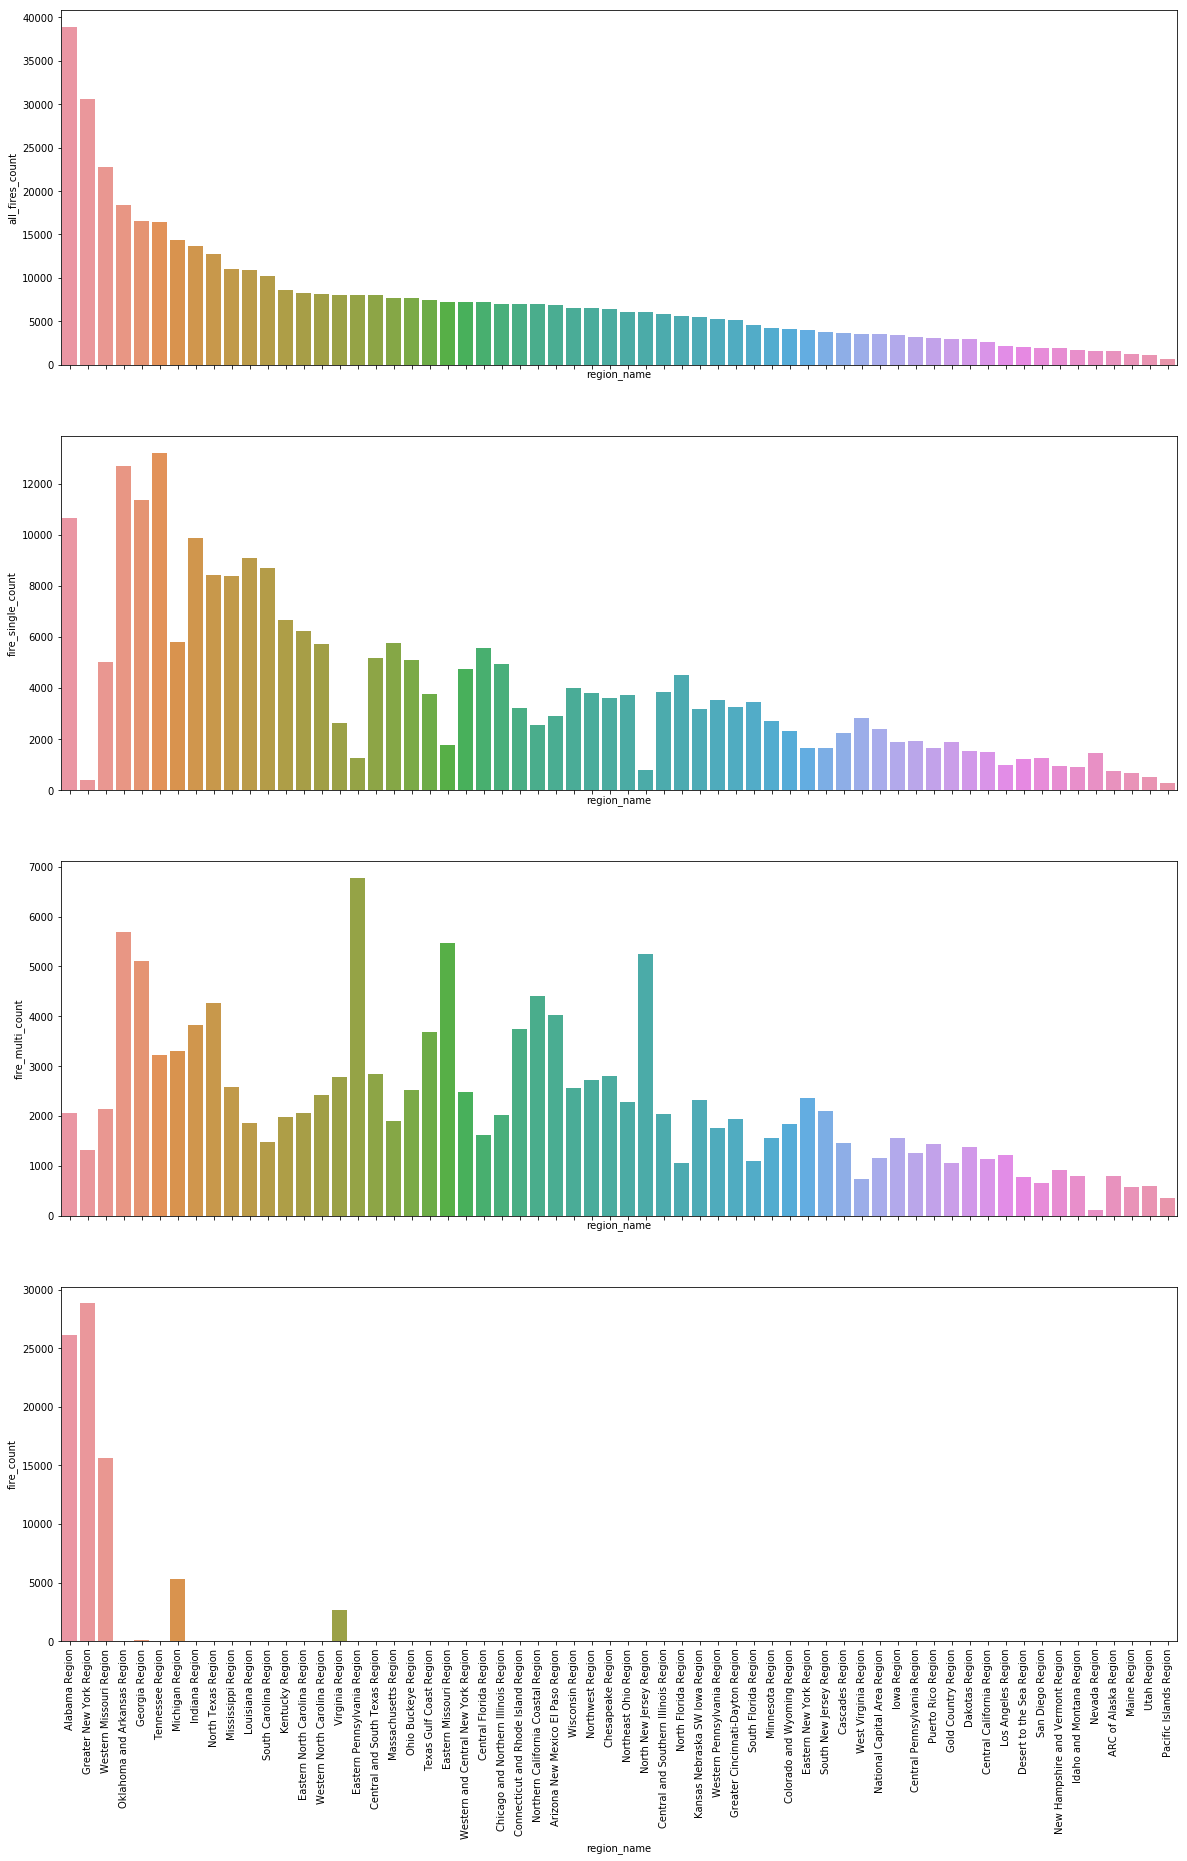

In [12]:
# Plot total fire cases against region
f, (ax1, ax2, ax3, ax4) = plt.subplots(4,1,figsize=(20,30), sharex = True)

ax1 = sns.barplot(y = rc_regions_fire['all_fires_count'], x = rc_regions['region_name'], ax = ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 90)

ax2 = sns.barplot(y = rc_regions_fire['fire_single_count'], x = rc_regions['region_name'], ax = ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 90)

ax3 = sns.barplot(y = rc_regions_fire['fire_multi_count'], x = rc_regions['region_name'], ax = ax3)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation = 90)

ax4 = sns.barplot(y = rc_regions_fire['fire_count'], x = rc_regions['region_name'], ax = ax4)
ax4.set_xticklabels(ax4.get_xticklabels(), rotation = 90)

plt.show()

In [13]:
# Age
raw.columns

Index(['case_num', 'incident_disaster_date', 'incident_disaster_num',
       'dr_type', 'event_type_old_categories', 'event_type_new_categories',
       'incident_disaster_fiscal_year', 'chapter_code', 'chapter_name',
       'region_code', 'region_name', 'division_name', 'pre_address',
       'pre_city', 'primary_affected_state', 'pre_zip_5_digit',
       'primary_affected_county', 'num_clients', 'num_cases_w_fin_assist',
       'age_5_or_under_num', 'age_62_to_69_num', 'age_6_to_61_num',
       'age_over_69_num', 'female_num', 'male_num', 'gender_undeclared_num',
       'afro_american_num', 'native_american_num', 'asian_num',
       'caucasian_num', 'hispanic_num', 'ethnicity_undeclared_num',
       'esri_longitude_x', 'esri_latitude_x', 'esri_single_address_string',
       'esri_address', 'esri_city', 'esri_state', 'esri_zip', 'Unnamed: 39',
       'Unnamed: 40'],
      dtype='object')

In [ ]:
temp_df = raw.groupby(['region_name','event_type_old_categories']).sum().reset_index()
temp_df = temp_df[temp_df['event_type_old_categories'] == 'Fire : Multi-Family']

f, ax = plt.subplots(figsize=(10,5))
ax = sns.barplot(y = temp_df['num_clients'], x = temp_df['region_name'])
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.show()

In [ ]:
temp_df = raw.groupby(['region_name','event_type_old_categories']).sum().reset_index()
temp_df = temp_df[temp_df['event_type_old_categories'] == 'Fire : Multi-Family']

f, ax = plt.subplots(figsize=(10,5))
ax = sns.barplot(y = temp_df['age_5_or_under_num'], x = temp_df['region_name'])
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.show()

In [ ]:
temp_df = raw.groupby(['region_name','event_type_old_categories']).sum().reset_index()
temp_df = temp_df[temp_df['event_type_old_categories'] == 'Fire : Multi-Family']

f, ax = plt.subplots(figsize=(10,5))
ax = sns.barplot(y = temp_df['age_5_or_under_num'], x = temp_df['region_name'])
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.show()

In [ ]:
temp_df = raw.groupby(['region_name','event_type_old_categories']).sum().reset_index()
temp_df = temp_df[temp_df['event_type_old_categories'] == 'Fire : Multi-Family']

f, ax = plt.subplots(figsize=(10,5))
ax = sns.barplot(y = temp_df['age_62_to_69_num'], x = temp_df['region_name'])
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.show()

In [ ]:
temp_df = raw.groupby(['region_name','event_type_old_categories']).sum().reset_index()
temp_df = temp_df[temp_df['event_type_old_categories'] == 'Fire : Multi-Family']

f, ax = plt.subplots(figsize=(10,5))
ax = sns.barplot(y = temp_df['age_6_to_61_num'], x = temp_df['region_name'])
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.show()

In [ ]:
temp_df = raw.groupby(['region_name','event_type_old_categories']).sum().reset_index()
temp_df = temp_df[temp_df['event_type_old_categories'] == 'Fire : Multi-Family']

f, ax = plt.subplots(figsize=(10,5))
ax = sns.barplot(y = temp_df['female_num'], x = temp_df['region_name'])
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.show()

In [ ]:
temp_df = raw.groupby(['region_name','event_type_old_categories']).sum().reset_index()
temp_df = temp_df[temp_df['event_type_old_categories'] == 'Fire : Multi-Family']

f, ax = plt.subplots(figsize=(10,5))
ax = sns.barplot(y = temp_df['age_62_to_69_num'], x = temp_df['region_name'])
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.show()

In [ ]:
temp_df = raw.groupby(['esri_state','event_type_old_categories']).sum().reset_index()
temp_df = temp_df[temp_df['event_type_old_categories'] == 'Fire : Multi-Family']

f, ax = plt.subplots(figsize=(10,5))
ax = sns.barplot(y = temp_df['num_clients'], x = temp_df['esri_state'])
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.show()

In [ ]:
temp_df = raw.groupby(['esri_state','event_type_old_categories']).sum().reset_index()

In [ ]:
temp_df